(chapter:tensors/tensor)=
# `Tensor`: vectorized computational graphs

Although `Scalar` provides a complete implementation for computational graphs, they are terribly hard to work with, not to mention their performance issues. As we've {ref}`seen it earlier <computational-graphs:mlp:a-multi-layer-network>`, training a simple neural net with a hidden layer of eight `Scalar` neurons takes a lot of time, and defining it without matrix multiplications is a pain.

Fortunately, we don't have to be so granular when defining computational graphs. Via the magic of linear algebra, we can seriously cut down the number of nodes and edges in our graphs, resulting in a blazing increase in speed and notational simplicity.

To give you an example, consider the dot product operation, defined by

$$
\mathbf{x} \cdot \mathbf{y} = \sum_{i=1}^{n} x_i y_i, \quad \mathbf{x}, \mathbf{y} \in \mathbb{R}^n.
$$

This is a computational graph that contains $4n - 1 $ nodes and $4n - 2 $ edges. Here it is for three-dimensional vectors.

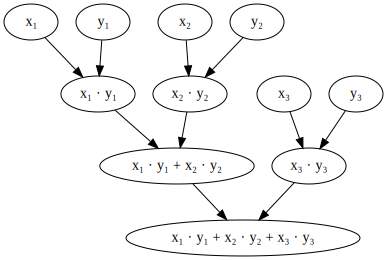

In [1]:
from graphviz import Digraph

graph = Digraph()
graph.node("a", "x₁")
graph.node("b", "x₂")
graph.node("c", "x₃")
graph.node("d", "y₁")
graph.node("e", "y₂")
graph.node("f", "y₃")
graph.node("g", "x₁ · y₁")
graph.node("h", "x₂ · y₂")
graph.node("i", "x₃ · y₃")
graph.node("j", "x₁ · y₁ + x₂ · y₂")
graph.node("k", "x₁ · y₁ + x₂ · y₂ + x₃ · y₃")
graph.edges(["ag", "dg", "bh", "eh", "ci", "fi", "gj", "hj", "ik", "jk"])

graph

Consider doing a backward pass in this graph: you have to traverse every node, every edge, and execute functions there. It's even worse for matrix multiplications, and the computational complexity piles up fast. For a basic one-layer network like $ \sigma(\mathrm{ReLU}(xA)B) $, we already have a ton of components. If the inputs are images, we are in the tens of thousands. That's not going to work out in the long run.

What if we replace scalars with vectors and matrices in our computational graphs?

This is how the dot product would look like:

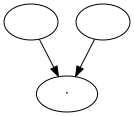

In [2]:
graph = Digraph()
graph.node("a", "𝐱")
graph.node("b", "𝐲")
graph.node("c", "𝐱 · 𝐲")
graph.edges(["ac", "bc"])

graph

Structurally, this is identical to the one of matrix multiplication:

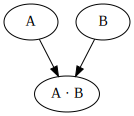

In [3]:
graph = Digraph()
graph.node("a", "A")
graph.node("b", "B")
graph.node("c", "A · B")
graph.edges(["ac", "bc"])

graph

This is what the `Tensor` class implements in `mlfz`. Let's see what tensors are!

## How to work with `Tensor`

Similarly to `Scalar`, the `Tensor` class is a node in a computational graph. This time, instead of a scalar value, they represent NumPy arrays.

In [4]:
import numpy as np
from mlfz.nn.tensor import Tensor


x = Tensor.ones(3, 4)
y = Tensor.zeros_like(x)

In [5]:
x + y

Tensor([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

A `Tensor` can be initialized in multiple ways; the principal one is via a NumPy array.

In [6]:
Tensor(np.array([[1, 2], [3, 4]]))

Tensor([[1, 2],
       [3, 4]])

In [7]:
Tensor.from_random(2, 4)

Tensor([[0.0971899 , 0.95210746, 0.25827259, 0.87312913],
       [0.20904163, 0.19959813, 0.03505771, 0.84271891]])

In [8]:
Tensor.zeros(5, 2)

Tensor([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [9]:
x = Tensor.zeros(3, 4)
Tensor.ones_like(x)

Tensor([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

Just like a `Scalar`, `Tensor` instances hold three important attributes as well:
* a tensor value,
* the backwards gradient,
* and the list of incoming edges.

In [10]:
x = Tensor.ones(3, 4)
y = Tensor.ones(3, 4)
z = x * y

In [11]:
z.backwards_grad    # this is a NumPy array

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [12]:
z.prevs   # and this is a list of Edges

[Edge(prev=Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), local_grad=array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), backward_fn=<function _pointwise at 0x7f447036a8e0>),
 Edge(prev=Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), local_grad=array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), backward_fn=<function _pointwise at 0x7f447036a8e0>)]

We'll talk about the `Edge` object later, but if you are observant, you may have noticed that compared to the `Scalar` version, we have an additional `backward_fn` attribute. This is the price we pay for vectorization.

First, let's see what `Tensor`s can do.

## `Tensor`s and operations

`Tensor`s support quite a few operations:
* pointwise addition `+`,
* pointwise subtraction `-`,
* pointwise multiplication `*`,
* pointwise division `/`,
* pointwise exponentiation `**`,
* matrix multiplication `@`, 
* and matrix transposition `T`.

Thanks to the broadcasting magic of NumPy, the other operand need not be a `Tensor`, it can be a vanilla Python number. (We'll open a whole other can of worms with broadcasting, but we'll cross that bridge later.)

In [13]:
x = Tensor.ones(3, 4)
2 + x

Tensor([[3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.]])

Just like `Scalar`s, we can apply functions to `Tensor`s. 

In [14]:
from mlfz.nn.tensor.functional import exp

x = Tensor(value=np.array([[1, 2], [3, 4]]))
exp(x)

Tensor([[ 2.71828183,  7.3890561 ],
       [20.08553692, 54.59815003]])

As a `Tensor` is essentially a wrapper over NumPy arrays, it has its own `sum` and `mean` methods, working identically to the original versions.

In [15]:
x = Tensor.ones(3, 4)
x.sum()

Tensor(12.)

In [16]:
x.sum(axis=0)

Tensor([3., 3., 3., 3.])

In [17]:
x.sum(axis=1)

Tensor([4., 4., 4.])

In [18]:
y = Tensor(np.array([[1, 2], [3, 4]]))
y.mean()

Tensor(2.5)

In [19]:
y.mean(axis=0)

Tensor([2., 3.])

## Computational graphs with `Tensor`s

Just like most features, the graph-building is the same as well: it is dynamically built upon applying functions and operations.

In [20]:
from mlfz.nn.tensor.functional import sigmoid, tanh

x = Tensor.from_random(1, 3)
A = Tensor.from_random(3, 5)
B = Tensor.from_random(5, 1)

y = sigmoid(tanh(x @ A) @ B)

In [21]:
y

Tensor([[0.92453201]])

In [22]:
y.shape

(1, 1)

Again, the `y.backward` method calculates the gradient of `y` with respect to all nodes in the graph. As our nodes are tensors, the backwards gradient will be a tensor as well, with the shape matching the node's shape.

In [23]:
y.backward()
x.backwards_grad

array([[0.02787502, 0.04271687, 0.01934118]])

In [24]:
A.backwards_grad

array([[0.0158382 , 0.02798379, 0.00553132, 0.00876583, 0.00406162],
       [0.01430759, 0.02527942, 0.00499677, 0.0079187 , 0.0036691 ],
       [0.0151315 , 0.02673515, 0.00528451, 0.0083747 , 0.00388039]])

In [25]:
B.backwards_grad

array([[0.05691973],
       [0.05061579],
       [0.06263128],
       [0.06274373],
       [0.05677851]])

In essence, tensors allow us to vectorize computational graphs, increasing the speed and simplicity like you wouldn't believe. Let's proceed to build one!